In [1]:
# import dependencies 
from fastai.vision.all import *
import timm
from torchvision import transforms
from pathlib import Path
from utils import get_y, create_dls, get_mean_table, dataset_forecast, adapt_model_to_new_dls, create_dls_stratified

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = 'PlantDoc'
model_architecture = 'efficientvit_b0'
epochs = 15

In [6]:
def iteratively_train_on_dataset_fractions(train_pcts = [0.25, 0.5, 0.65], replicates=1, dataset_path='data/PlantDoc/data/'):
    results_table = pd.DataFrame(columns=['train_pct', 'acc'])
    for train_pct in train_pcts:
        print(f'Creating DL: {train_pct}')
        dls = create_dls_stratified(train_pct, dataset_path)
        for replicate in range(replicates): # repeat training and average results for increased accuracy 
            print(f'{train_pct} replicate {replicate}')
            # fine tune model
            model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
            learn = Learner(dls, model, metrics=accuracy)
            learn.fine_tune(epochs=15)
            val_acc = learn.recorder.values[-1][2]
            row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
            results_table = pd.concat([results_table, row])
    mean_table = get_mean_table(results_table)
    return mean_table

In [7]:
mean_table = iteratively_train_on_dataset_fractions()

Creating DL: 0.25
0.25 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,3.383662,2.614080,0.297849,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.977479,2.218547,0.375269,00:09
1,0.718360,2.030091,0.427957,00:09
2,0.510921,2.039009,0.480108,00:09
3,0.372477,2.104207,0.488710,00:10
4,0.291463,2.125531,0.503763,00:09
5,0.242177,2.173894,0.499462,00:09
6,0.210513,2.148441,0.499462,00:10
7,0.182060,2.303010,0.489785,00:10
8,0.154387,2.311619,0.501613,00:09
9,0.136012,2.236882,0.506989,00:09


/tmp/ipykernel_8903/2442918035.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, row])


Creating DL: 0.5
0.5 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,2.842985,2.073166,0.412903,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.793881,1.631276,0.533871,00:10
1,0.519634,1.555533,0.564516,00:10
2,0.373057,1.727105,0.540323,00:10
3,0.305890,1.999567,0.514516,00:11
4,0.319791,2.323938,0.526613,00:10
5,0.336853,2.245342,0.511290,00:10
6,0.341897,2.228047,0.532258,00:10
7,0.313123,2.135472,0.548387,00:11
8,0.249903,2.146440,0.572581,00:10
9,0.197308,2.032458,0.575000,00:10


Creating DL: 0.65
0.65 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,2.687993,2.119292,0.417051,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.850451,1.362879,0.587558,00:09
1,0.570641,1.344043,0.610599,00:09
2,0.422683,1.418382,0.614055,00:10
3,0.369053,1.807644,0.576037,00:09
4,0.398092,2.115168,0.493088,00:09
5,0.428524,1.987355,0.576037,00:10
6,0.365608,1.842985,0.579493,00:09
7,0.285437,1.869395,0.599078,00:10
8,0.223308,1.835780,0.594470,00:09
9,0.172960,1.805512,0.619816,00:09


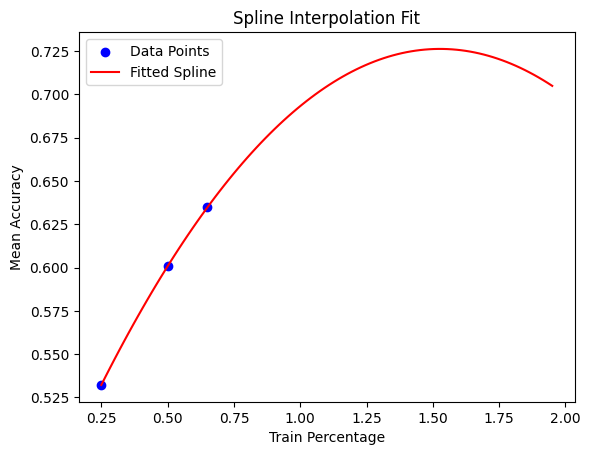

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def dataset_forecast_spline(mean_table):
    # Extracting x and y values from the DataFrame
    x = mean_table['train_pct']
    y = mean_table['mean_acc']

    # Creating the spline model
    spline_degree = 2  # Adjusted degree of the spline
    spline_model = UnivariateSpline(x, y, k=spline_degree)

    # Extending the x range
    x_min = min(x)
    x_max = max(x)
    x_extension = 3.0
    extended_x_max = x_max * x_extension

    x_line = np.linspace(x_min, extended_x_max, 100)
    y_line = spline_model(x_line)

    # Plotting
    plt.scatter(x, y, color='blue', label='Data Points')
    plt.plot(x_line, y_line, color='red', label='Fitted Spline')

    plt.xlabel('Train Percentage')
    plt.ylabel('Mean Accuracy')
    plt.title('Spline Interpolation Fit')
    plt.legend()
    plt.show()

    return spline_model, plt.plot

# Example usage
# mean_table = pd.DataFrame({'train_pct': [10, 20, 30, ...], 'mean_acc': [0.5, 0.6, 0.7, ...]})
spline_model, plot_function = dataset_forecast_spline(mean_table)


In [24]:
def dataset_forecast(mean_table):
    # Assuming 'mean_table' is your DataFrame with 'train_pct' and 'mean_acc'
    x = mean_table['train_pct']
    y = mean_table['mean_acc']

    # Choose the degree of the polynomial (e.g., 2 for quadratic)
    degree = 2

    # Fit the polynomial regression model
    coefficients = np.polyfit(x, y, degree)

    # Use the fitted model to predict values
    polynomial = np.poly1d(coefficients)

    # Extend the range of x_line beyond the maximum x value
    x_min = min(x)
    x_max = max(x)  # Maximum value in your data
    x_extension = 5.0  # For example, extend by 20%
    extended_x_max = x_max * x_extension

    x_line = np.linspace(x_min, extended_x_max, 100)
    y_line = polynomial(x_line)

    # Plotting the original data points
    plt.scatter(x, y, color='blue', label='Data Points')

    # Plotting the fitted curve over the extended range
    plt.plot(x_line, y_line, color='red', label='Fitted Curve')

    plt.xlabel('Train Percentage')
    plt.ylabel('Mean Accuracy')
    plt.title('Polynomial Regression Fit')
    plt.legend()
    plt.show()
    return polynomial

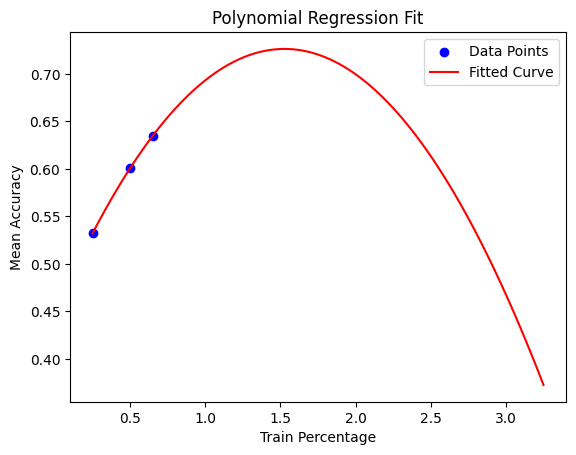

poly1d([-0.11904796,  0.3634795 ,  0.44882872])

In [25]:
dataset_forecast(mean_table)

In [ ]:
percentage_of_data = 0.9
predicted_accuracy = polynomial(percentage_of_data)
predicted_accuracy

In [ ]:
train_pcts = [0.9]
replicates = 3
results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct)
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        results_table = pd.concat([results_table, row])

mean_table = pd.concat([mean_table, get_mean_table(results_table)])
mean_table = mean_table.reset_index()

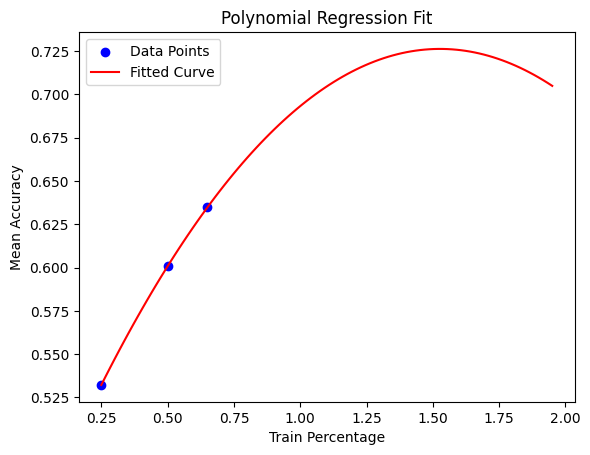

In [19]:
# plot polynomial here
polynomial = dataset_forecast(mean_table)

In [ ]:
percentage_of_data = 0.95
predicted_accuracy = polynomial(percentage_of_data)
predicted_accuracy

In [ ]:
# Resnet-18
# epoch	train_loss	valid_loss	accuracy	time
# 0	2.329669	2.175517	0.398039	04:44
# 1	2.047739	1.710715	0.527451	04:47
# 2	1.696105	1.822478	0.431373	04:57
# 3	1.373082	1.125379	0.621569	05:14
# 4	1.118939	1.178962	0.613725	05:16
# 5	0.903016	1.063396	0.656863	05:16
# 6	0.726309	0.970530	0.662745	05:16
# 7	0.587566	0.937186	0.670588	05:15
# 8	0.492905	0.925825	0.688235	05:04
# 9	0.435941	0.922592	0.692157	04:56

In [ ]:
learn.save('fine_tuned_model')

In [ ]:
train_pcts = [0.1, 0.25, 0.5, 0.65]
replicates = 3
field_plant_results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct, 'plantvillage-dataset/color')
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        field_plant_results_table = pd.concat([field_plant_results_table, row])

In [ ]:
# polynomial = dataset_forecast(field_plant_results_table)

In [ ]:
train_pcts = [0.1, 0.25, 0.5, 0.65]
replicates = 3
field_plant_results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct, 'plantvillage-dataset/segmented')
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        field_plant_results_table = pd.concat([field_plant_results_table, row])

In [ ]:
dls = create_dls(0.8, 'plantvillage-dataset/segmented')
# for replicate in range(replicates): # repeat training and average results for increased accuracy 
# print(f'{train_pct} replicate {replicate}')
# # fine tune model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fine_tune(epochs=15)

In [ ]:
dls = create_dls(0.8, 'plantvillage-dataset/color')
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fine_tune(epochs=1)
learn.recorder.plot_loss() 

In [ ]:
# Load the new dataset
dls = create_dls_stratified(0.5, 'FieldPlant-dataset')

In [ ]:
learn2 = adapt_model_to_new_dls(learn, dls)    
learn2.validate()


In [20]:
timm.list_models('*VIT*')


['convit_base',
 'convit_small',
 'convit_tiny',
 'crossvit_9_240',
 'crossvit_9_dagger_240',
 'crossvit_15_240',
 'crossvit_15_dagger_240',
 'crossvit_15_dagger_408',
 'crossvit_18_240',
 'crossvit_18_dagger_240',
 'crossvit_18_dagger_408',
 'crossvit_base_240',
 'crossvit_small_240',
 'crossvit_tiny_240',
 'davit_base',
 'davit_giant',
 'davit_huge',
 'davit_large',
 'davit_small',
 'davit_tiny',
 'efficientvit_b0',
 'efficientvit_b1',
 'efficientvit_b2',
 'efficientvit_b3',
 'efficientvit_l1',
 'efficientvit_l2',
 'efficientvit_l3',
 'efficientvit_m0',
 'efficientvit_m1',
 'efficientvit_m2',
 'efficientvit_m3',
 'efficientvit_m4',
 'efficientvit_m5',
 'fastvit_ma36',
 'fastvit_s12',
 'fastvit_sa12',
 'fastvit_sa24',
 'fastvit_sa36',
 'fastvit_t8',
 'fastvit_t12',
 'flexivit_base',
 'flexivit_large',
 'flexivit_small',
 'gcvit_base',
 'gcvit_small',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_256d',
 'levit_384',
 '

In [25]:
# List all available models in timm and check if 'seresnextnet50' or similar exists
model_names = timm.list_models()
similar_models = [model for model in model_names if "seresnext" in model]

similar_models

['legacy_seresnext26_32x4d',
 'legacy_seresnext50_32x4d',
 'legacy_seresnext101_32x4d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext26ts',
 'seresnext50_32x4d',
 'seresnext101_32x4d',
 'seresnext101_32x8d',
 'seresnext101_64x4d',
 'seresnext101d_32x8d',
 'seresnextaa101d_32x8d',
 'seresnextaa201d_32x8d']

In [26]:
model = timm.create_model('seresnext50_32x4d', pretrained=False)

# Counting the number of parameters
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 27559896


In [27]:
model = timm.create_model('resnet50', pretrained=False)

# Counting the number of parameters
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 25557032
